## Uvod u Znanost o podacima - Sara Sičić

------------------------------

### Članak: Metabolism-associated molecular classiﬁcation of hepatocellular carcinoma

Karcinom jetre jedan je od najkompliciranijih karcinoma zbog velike raznolikosti gena koji su ekspresirani u uzorcima karcinoma. To znatno otežava i analizu podataka i liječenje pacijenata. Cilj članka je podijeliti uzorke karcinoma jetre u tri grupe (klastera), od kojih svaka grupa ima određene karakteristike, npr. dobra prognoza ili loša prognoza, te na temelju 90 metaboličkih gena predvidjeti kojoj grupi karcinom pripada.

------------------------------


In [1]:
import sys
import pandas as pd
import numpy as np
from gtfparse import read_gtf
import csv
from tabulate import tabulate
import os
import gzip
import xlrd
import shutil
from scipy import stats
from os import listdir
from os.path import isfile, join
from combat.pycombat import pycombat

import scipy as sp
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#!{sys.executable} -m pip install gtfparse
#!{sys.executable} -m pip install tabulate
#!{sys.executable} -m pip install xlrd
#!{sys.executable} -m pip install lifelines
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install combat --user
#!{sys.executable} -m pip install scikit-survival
#!{sys.executable} -m pip install xlrd
#!{sys.executable} -m pip install kneed

### 0) Provjera podataka

***Prokomentirajte vrstu istraživanja provedenu u članku prema: svrsi, izvoru informacija, vremenu provedbe, načinu prikupljanja i vrsti korištenih podataka, stupnju manipulacije varijablama, dubini i vrsti zaključka - obrazložite svoj izbor za svaku pojedinu podjelu.***
<br> <br>
Vrsta istraživanja u ovom članku prema svrsi je primijenjeno istraživanje s obzirom da je fokusirano na stvaranje praktičnog znanstvenog znanja. Na temelju podataka pacijenata koji su imali karcinom jetre nastoje se karakterizirati molekularna svojstva karcinoma jetre razvojem sustava klasifikacije koji se temelji na profilu ekspresije metaboličkih gena.
<br>
Prema izvoru informacija ovo istraživanje je sekundarno istraživanje, s obzirom da su istraživači koristili podatke koje nisu sami sastavili.
<br>
Ovo istraživanje je sinkrono istraživanje po vremenu provedbe s obzirom da uzima podatke iz jedne točke u vremenu za svakog pacijenta.
<br>
Prema načinu prikupljanja korištenih podataka ovo istraživanje je dokumentarno istraživanje s obzirom da su gotovi podaci preuzeti sa istraživačkih web-stranica.
<br>
Istraživanje je kvantitativno prema vrsti korištenih podataka jer koristi mjerljive podatke o pacijentima kako bi se uz.
<br>
S obzirom na stupanj manipulacije varijablama, ovo istraživanje je promatračko zato što istraživači ne interveniraju izravno već analiziraju karcinom jetre u njegovom prirodnom kontekstu.
<br>
Prema dubini ovo je istraživačko istraživanje jer se temelji na proučavanju slabo proučavanih pojava i manje se oslanja na teoriju, a više na prikupljanje podataka. 
<br>
Ovo istraživanje je prema vrsti zaključka hipotetičko-deduktivno s obzirom da se na početku istraživanja postavlja hipoteza o mogućnosti klasifikacije karcinoma jetre na temelju metaboličkih gena.
<br>

***Prokomentirajte metode kako su podaci za članak prikupljeni.***
<br> <br>
Prema metodama s kojima su podaci za ovaj članak prikupljeni, ovo je dokumentarno istraživanje zato što su to podaci prikupljeni s javno dostupnih web-stranica koje sadrže podatke namijenjene istraživačkoj zajednici.

***Provjerite jesu li podaci prikupljeni i objavljeni prema pravilima istraživačke etike.***
<br> <br>
Na stranici TCGA pronašla sam da su oformili skupinu koja se bavi etikom, zakonom i politikom čiji je cilj pravedna i efektivna uporaba podataka genomnih podataka vezanih uz rak. Oni tvrde da pri pikupljanju svojih podataka nastoje osigurati zaštitu sudionika u projektu, uključujući i njihovu privatnost, siguran pristup TCGA podacima te pravovremen pristup podacima istraživačkoj zajednici. <br>ICGC ARGO, odakle sam preuzela ICGC podatke za istraživanje, ima etički okvir za partnerstva s industrijom čija su temeljna načela uzajamnost, transparentnost, odgovornost, akademska sloboda i društvena korist. ICGC ARGO također ima radnu skupinu za etiku, politiku i upravljanje AEGC čiji je cilj podržati ICGC ARGO s etičkim načelima i smjernicama koje osiguravaju odgovarajuću obradu podataka od pacijenata u skladu s etičkim, pravnim i socijalnim pitanjima.

### 1) Priprema podataka

Podatke sam sve stavila u folder "files", unzippala sam ih i ostavila originalna imena, jedino sam tcga podatke extractala u folder "tcga".

In [3]:
path = 'C:/Users/Sara/Documents/My Fax/UZOP/files/'

In [4]:
#metabolicki geni
df = pd.ExcelFile(path + '41586_2011_BFnature10350_MOESM321_ESM.xls').parse('All metabolic genes') #you could add index_col=0 if there's an index
gene_set=set()
for cell in df['Gene Symbol']:
    gene_set.add(cell)
    

In [5]:
#anotacije
annot = read_gtf(path + 'gencode.v22.annotation.gtf')
gene_dict_id = dict()
gene_dict_len = dict()

gene_set_2 = set()
for i in range (0, len(annot)):
    if annot["gene_name"][i].upper() in gene_set:
        if ((annot["end"][i]-annot["start"][i])!=0):
            gene_set_2.add(annot["gene_name"][i])
            gene_dict_id[annot["gene_id"][i]]=annot["gene_name"][i]
            gene_dict_len[annot["gene_name"][i]]=annot["end"][i]-annot["start"][i]
            

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'tag', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [6]:
#icgc ucitavanje
file_icgc = open(path + 'exp_seq.tsv')
icgc_df = pd.read_csv(file_icgc, delimiter="\t")
icgc_df = icgc_df.loc[:, ['icgc_donor_id','gene_id','raw_read_count']]
icgc_df = icgc_df[icgc_df['gene_id'].isin(gene_set_2)]

In [7]:
#icgc tpm
icgc_count = dict()
icgc_data = []

for index, row in icgc_df.iterrows():
    rrc0 = float(row['raw_read_count'])
    genelen = float(gene_dict_len[row['gene_id']])
    rrc = rrc0/genelen
    icgc_data.append([row['icgc_donor_id'], row['gene_id'], rrc])
    if row['icgc_donor_id'] not in icgc_count:
        icgc_count[row['icgc_donor_id']]=rrc
    else:
        icgc_count[row['icgc_donor_id']]+=rrc         
        
for row in icgc_data:
    row[2] = row[2] / icgc_count[row[0]] * 1000000
    
icgc_df = pd.DataFrame(icgc_data, columns=['donor_id','gene_id','raw_read_count'])
print(icgc_df)

        donor_id  gene_id  raw_read_count
0        DO50855    SGPP1        3.874531
1        DO50855  SLC37A2        0.285830
2        DO50855  SLC6A11        2.827911
3        DO50855     DERA       45.659909
4        DO50855  PLA2G4E        0.112523
...          ...      ...             ...
1070522  DO23508    COX8C        0.003774
1070523  DO23508    KCNC3        0.159332
1070524  DO23508   SLC3A1        2.772726
1070525  DO23508    ACAD8        2.993089
1070526  DO23508     PFKP        3.124463

[1070527 rows x 3 columns]


In [8]:
#tcga ucitavanje
dir_tcga = os.listdir(path + 'tcga')
n=0
data = []
for dir in dir_tcga:
    n += 1
    dirName = path + 'tcga/'+dir
    for f in listdir(dirName):
        if (f.endswith('gz')):
            file = dirName+'/'+ f
            patientName = f[0:len(f)-16]
            tcgaFile = pd.read_csv(file, compression='gzip', sep='\t')
            for index, row in tcgaFile.iterrows():
                geneid = tcgaFile.iloc[index,0]
                if geneid in gene_dict_id:
                    if gene_dict_id[geneid] in gene_set_2:
                        data.append([patientName, gene_dict_id[geneid], tcgaFile.iloc[index,1] ])
    if (n==5):
        break
        
tcga_df = pd.DataFrame(data, columns=['donor_id','gene_id','raw_read_count'])

TCGA mi se sporo učitava i zauzima puno memorije pa sam učitala samo prvih 5 pacijenata.

In [9]:
#tcga tpm
tcga_count = dict()
tcga_data = []

for index, row in tcga_df.iterrows():
    rrc0 = float(row['raw_read_count'])
    genelen = float(gene_dict_len[row['gene_id']])
    rrc = rrc0/genelen
    tcga_data.append([row['donor_id'], row['gene_id'], rrc])
    if row['donor_id'] not in tcga_count:
        tcga_count[row['donor_id']]=rrc
    else:
        tcga_count[row['donor_id']]+=rrc         
for row in tcga_data:
    row[2] = row[2] / tcga_count[row[0]] * 1000000
        
tcga_df = pd.DataFrame(tcga_data, columns=['donor_id','gene_id','raw_read_count'])
print(tcga_df)

                                   donor_id  gene_id  raw_read_count
0      358f2893-02b2-4d36-9c76-b818c28b6027     DPM1      211.884187
1      358f2893-02b2-4d36-9c76-b818c28b6027    FUCA2       26.302756
2      358f2893-02b2-4d36-9c76-b818c28b6027     GCLC      983.494482
3      358f2893-02b2-4d36-9c76-b818c28b6027    ENPP4        0.153667
4      358f2893-02b2-4d36-9c76-b818c28b6027     CFTR        1.364078
...                                     ...      ...             ...
13260  fe506b98-0733-43c9-943a-be9b12f1c2fb    DHRSX        0.000000
13261  fe506b98-0733-43c9-943a-be9b12f1c2fb    ASMTL        0.000000
13262  fe506b98-0733-43c9-943a-be9b12f1c2fb  SLC25A6        0.000000
13263  fe506b98-0733-43c9-943a-be9b12f1c2fb   PLCXD1        0.000000
13264  fe506b98-0733-43c9-943a-be9b12f1c2fb     ASMT        0.000000

[13265 rows x 3 columns]


In [10]:
icgc_df_new = icgc_df.rename(columns={"icgc_donor_id": "donor_id"})
result_df = pd.concat([icgc_df_new, tcga_df], axis=0)
result_df.fillna(0)
result_df = result_df.reset_index().drop(columns=['index'])
print(result_df)

                                     donor_id  gene_id  raw_read_count
0                                     DO50855    SGPP1        3.874531
1                                     DO50855  SLC37A2        0.285830
2                                     DO50855  SLC6A11        2.827911
3                                     DO50855     DERA       45.659909
4                                     DO50855  PLA2G4E        0.112523
...                                       ...      ...             ...
1083787  fe506b98-0733-43c9-943a-be9b12f1c2fb    DHRSX        0.000000
1083788  fe506b98-0733-43c9-943a-be9b12f1c2fb    ASMTL        0.000000
1083789  fe506b98-0733-43c9-943a-be9b12f1c2fb  SLC25A6        0.000000
1083790  fe506b98-0733-43c9-943a-be9b12f1c2fb   PLCXD1        0.000000
1083791  fe506b98-0733-43c9-943a-be9b12f1c2fb     ASMT        0.000000

[1083792 rows x 3 columns]


In [11]:
pivoted_df = result_df.pivot_table(index=["gene_id"], columns=["donor_id"], values=['raw_read_count']).fillna(0)
pivoted_df = pivoted_df['raw_read_count']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
icgc_pivot = icgc_df_new.reset_index().drop(columns=['index']).pivot_table(index=["gene_id"], columns=["donor_id"], values=['raw_read_count'])['raw_read_count']
tcga_pivot = tcga_df.reset_index().drop(columns=['index']).pivot_table(index=["gene_id"], columns=["donor_id"], values=['raw_read_count'])['raw_read_count']

In [13]:
#pycombat
batch = []
datasets = [icgc_pivot, tcga_pivot]

for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])

df_corrected = pycombat(pivoted_df,batch)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/Users/svenalmer/opt/anaconda3/lib/python3.8/site-packages/combat/pycombat.py:160: RuntimeWarning: divide by zero encountered in true_divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


PyComBat mi se povremeno pokrene bez greške, a povremeno sa ZeroDivision Error.

In [14]:
pivoted_df = df_corrected

### 2) Odabir bitnih gena i klasteriranje

In [15]:
#MAD
#>0.5
n = 0
new_genes = set()
counts_mad = dict()
for index, row in pivoted_df.iterrows():
    for r in row:
        if index not in counts_mad:
            counts_mad[index] = [r]
        else:
            counts_mad[index].append(r)
for key in counts_mad:
    if (sp.stats.median_abs_deviation(counts_mad[key])>0.5):
        new_genes.add(key)
mad_df = pivoted_df.loc[pivoted_df.index.isin(new_genes)]
mad_t_df = mad_df.T

In [16]:
#uctavanje survival podataka
dfile1 = open(path + 'donor.tsv')
icgc_donor = pd.read_csv(dfile1, delimiter="\t")
dfile2 = open(path + 'clinical.tsv')
tcga_donor = pd.read_csv(dfile2, delimiter="\t")

survivalDict = dict()
icgc_donor_df = icgc_donor.loc[:,['icgc_donor_id', 'donor_vital_status', 'donor_survival_time']];
icgc_donor_df.rename(columns={'icgc_donor_id':'donor_id', 'donor_vital_status':'status', 'donor_survival_time':'time'}, inplace=True)
tcga_donor_df = tcga_donor.loc[:,['case_id', 'vital_status', 'days_to_death']];
tcga_donor_df.rename(columns={'case_id':'donor_id', 'vital_status':'status', 'days_to_death':'time'}, inplace=True)
tcga_donor_df['time'] = np.where((tcga_donor_df.time == '\'--'),'100000',tcga_donor_df.time)

In [17]:
donor_df = pd.concat([icgc_donor_df,tcga_donor_df], axis=0)
donor_df = donor_df.set_index('donor_id')
mad_t_df = mad_t_df.reset_index().set_index('donor_id')

drop_mad_df = mad_t_df[mad_t_df.index.isin(donor_df.index)]
drop_donor_df = donor_df[donor_df.index.isin(mad_t_df.index)]
drop_mad_df = drop_mad_df[drop_mad_df.index.isin(drop_donor_df.index)]
drop_mad_df = drop_mad_df[~drop_mad_df.index.duplicated(keep='first')]
donor_df = pd.concat([drop_mad_df, drop_donor_df], axis=1, join='inner')

print(donor_df)

                 A1CF       AACS        AADAC      AADAT      AASDH  AASDHPPT  \
donor_id                                                                        
DO227643   666.443040   6.025463  3172.896046  47.862779   5.952881  1.333268   
DO227801   696.116587   8.332583  3293.125462  74.780821   7.373974  1.827766   
DO23508    552.925658  31.752660  2414.405278  67.041188   6.031856  1.375836   
DO23509    827.215354  16.266381  2496.671611  72.443678   8.519673  2.730933   
DO23510    957.975042  17.367144  3886.712375  74.716572   8.968047  3.255191   
...               ...        ...          ...        ...        ...       ...   
DO50845   1657.862191  99.985696  5269.630453  62.813509  24.946456  4.731455   
DO50850   1236.919901  19.590948  3416.241758  91.807995  15.985309  4.171051   
DO50855    803.014330  53.785782  4205.318031  95.357970  10.972342  3.757484   
DO50857   1323.961958  25.329886  3991.268015  31.109102  24.382298  3.971920   
DO50859   1151.108664  15.00

In [18]:
#COX analiza
coxphf = CoxPHFitter(penalizer=0.1, alpha=0.05)
cpf_donor_df = donor_df.reset_index().drop(['donor_id'], axis=1)
cpf_donor_df["status"] = cpf_donor_df["status"].map(lambda x: 0 if x == 'alive' else 1)
coxphf.fit(cpf_donor_df, event_col='status', duration_col='time')

<lifelines.CoxPHFitter: fitted with 232 total observations, 189 right-censored observations>

Pri COX analizi stavila sam penalizer na vrijednost 0.9 zbog kolinearnosti u matrici koju mu predajem.

In [19]:
cox_genes = set()
for i in coxphf.params_.index:
    cox_genes.add(i)
print(len(cox_genes))

1875


In [20]:
cox_df = mad_df[mad_df.index.isin(cox_genes)]

In [21]:
#KMeans
km_df = cox_df.T #koristim mad_df koji je bez survival podataka, zato ne koristimo mad_t_df - tom su dodani survival podaci
print(km_df.shape)
model = KMeans(
    init="k-means++",
    n_clusters=3,
    n_init=4,
    max_iter=300,
    )

(237, 1875)


[0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 2 1 1 0 1 1 0 0 2 1 1 0 1 0 1 0 1 1 2
 1 0 1 1 0 1 2 1 2 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 1 0 2 2 0 0 2 0 0 0 0 1 0 0 0 0 1 0 0 2 2 1 0 0 0 1 0 0 1 0 2 2 0
 0 1 1 1 1 0 0 0 0 2 0 1 0 0 0 2 1 0 1 1 1 1 1 0 0 0 0 0 0 1 2 0 0 0 0 0 1
 1 2 0 0 2 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1
 0 1 0 1 0 0 0 0 1 0 1 2 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 2 1 2 2 1 1 1
 2 0 0 0 2 0 2 0 2 2 0 1 1 0 0]


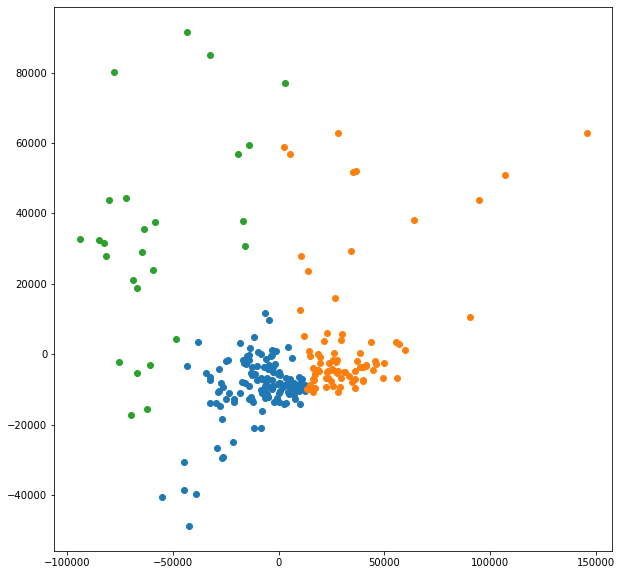

In [22]:
pca = PCA(n_components = 2)
data = pca.fit_transform(km_df)
label = model.fit_predict(km_df)
print(label)
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)

#### K-medians
Clustering ćemo napraviti i algoritmom K-medians te usporediti rezultate.

S obzirom da ne postoji gotova implementacija K-medians algoritma, izradit ćemo svoju.

In [23]:
from tqdm import tqdm

class KMedians:
    
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
    def manhattan_distance(self, x1, x2):
        diff = abs(x1 - x2)
        return sum(diff)
    
    def assign_to_clusters(self, X, centroids):
        c = []
        for x in X:
            idx = -1
            min_dist = np.inf
            for i,j in enumerate(centroids):
                dist = self.manhattan_distance(x, j)
                if dist < min_dist:
                    idx = i
                    min_dist = dist
            c.append(idx)
        return c
    
    def shift_centroids(self, X, c):
        clusters = {}
        for i in set(c):
            clusters[i] = []
           
        for x,clster in zip(X, c):
            clusters[clster].append(x)
        
        medians = []
        for x in clusters.values():
            temp =  x[0]
            for i in x[1:]:
                temp = np.c_[temp,i]
            if temp.ndim == 1:
                temp = temp.reshape(-1,len(temp))
            temp = np.median(temp, axis=1)   
            medians.append(temp)
        
        return medians
    
    def calculate_cost(self, X, c, centroids):
        cost = sum([self.manhattan_distance(i, centroids[c[idx]]) for idx, i in enumerate(X)])
        cost /= float(X.shape[0])
        return cost
    
    def fit(self, X):
        best = np.inf
        self.centroids = None
        
        for itr in tqdm(range(self.max_iter)):
            centroid_idx = np.random.choice(range(X.shape[0]), size=self.n_clusters, replace=False)
            centroids = X[centroid_idx]
            
            # Calculate index of closest cluster centroid for each instance.
            c = self.assign_to_clusters(X, centroids)
        
            # Shift the cluster centroids.
            centroids = self.shift_centroids(X, c)
            
            # Calculate the value of the cost function.
            cost = self.calculate_cost(X, c, centroids)
            
            # Store best cluster centroids.
            if cost < best:
                best = cost
                self.centroids = centroids

    def predict(self, X):
        cluster = -np.ones(X.shape[0])
        min_dist = np.inf * np.ones(X.shape[0])
        for idx,i in enumerate(self.centroids):
            for j in range(X.shape[0]):
                dist = self.manhattan_distance(X[j], i)
                if dist < min_dist[j]:
                    min_dist[j] = dist
                    cluster[j] = idx
        return cluster
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

100%|██████████| 300/300 [02:28<00:00,  2.02it/s]


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 2. 2. 2. 0. 2. 0. 1. 2. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 0. 2. 1. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 0. 2. 0. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2.
 2. 0. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0.
 2. 2. 1. 2. 0. 2. 0. 2. 2. 2. 1. 2. 0. 2. 1. 1. 2. 0. 2. 2. 2.]


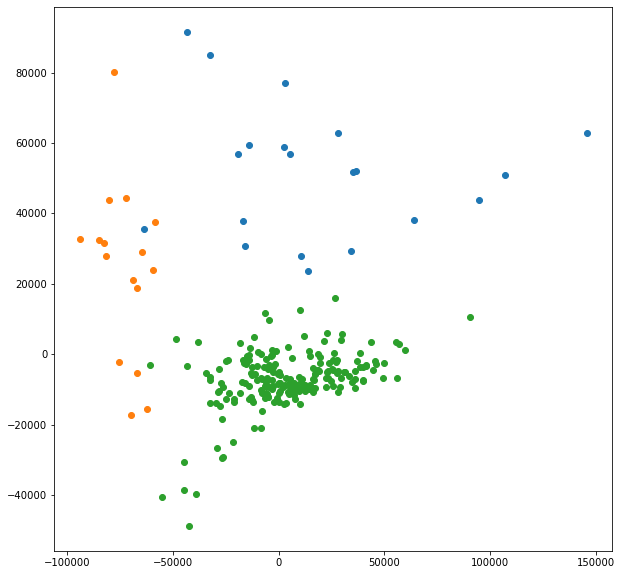

In [24]:
#KMedians
km_df = cox_df.T
model = KMedians(n_clusters=3, max_iter=300)

pca = PCA(n_components = 2)
data = pca.fit_transform(km_df)
label2 = model.fit_predict(km_df.to_numpy())
#for i in range(len(label2)):
print(label2)
plt.figure(figsize=(10,10))
uniq = np.unique(label2)
for i in uniq:
   plt.scatter(data[label2 == i , 0] , data[label2 == i , 1] , label = i)

Kada clustering radimo pomocu k-medians, dolazi do neravnoteze u brojevima primjera u klasama.

### 3)	Klasifikacija pomoću 90 gena
Zadnji korak u ovom projektu je treniranje klasifikatora koji na temelju 90 najznačajnijih gena određuje kojem klasteru (C1, C2, ili C3) pripada karcinom.

In [25]:
#feature selection algoritam
from sklearn.model_selection import train_test_split

train_df = cox_df.T
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(train_df, label, test_size=0.4, random_state=0)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

sel_kbest = SelectKBest(chi2, k=90)
select_df = sel_kbest.fit_transform(X_train, y_train)
select_df_test = sel_kbest.transform(X_test)
print(select_df)
print(select_df.shape)

[[0.09108604 0.00350212 0.15658436 ... 0.05711841 0.04614343 0.07412568]
 [0.78022865 0.0603289  0.65943302 ... 0.80398895 0.3878532  0.36648601]
 [0.45484894 0.14127669 0.23309524 ... 0.14314569 0.06386805 0.13326148]
 ...
 [0.09365586 0.10758245 0.10407904 ... 0.06804973 0.10708035 0.09494795]
 [0.16752509 0.02813461 0.19387906 ... 0.06883996 0.1608145  0.16047271]
 [0.17864157 0.09294637 0.17892686 ... 0.10443513 0.10287471 0.13651923]]
(142, 90)


U proširenoj verziji istraživanja provedena je usporedba algoritama odabira 90 najznačajnih značajki te prikazani rezultati algoritama. Podjeljen je skup podataka na skup podataka za učenje modela i skup podataka za treniranje modela.

In [26]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2

var_thr = VarianceThreshold(threshold=(.0263 * (1 - .0263)))
select_df2 = var_thr.fit_transform(X_train)
select_df2_test = var_thr.transform(X_test)
print(select_df2.shape)

fvalue_selector = SelectKBest(f_classif, k=90)
select_df3 = fvalue_selector.fit_transform(X_train, y_train)
select_df3_test = fvalue_selector.transform(X_test)
print(select_df3.shape)

(142, 338)
(142, 90)


In [27]:
#klasifikator SVM
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(select_df, y_train)
y_pred = clf.predict(select_df_test)
print(y_pred)

clf.fit(select_df2, y_train)
y_pred2 = clf.predict(select_df2_test)
clf.fit(select_df3, y_train)
y_pred3 = clf.predict(select_df3_test)

[0 2 0 2 0 0 2 0 2 1 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 1 0 0
 0 0 0 0 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 2
 1 2 0 0 0 1 0 0 0 2 1 0 1 0 0 0 0 0 2 2 0]


In [28]:
#prikaz rezultata
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.67      0.87      0.76        54
           1       0.50      0.19      0.27        27
           2       0.80      0.86      0.83        14

    accuracy                           0.67        95
   macro avg       0.66      0.64      0.62        95
weighted avg       0.64      0.67      0.63        95

[[47  5  2]
 [21  5  1]
 [ 2  0 12]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        54
           1       0.79      0.70      0.75        27
           2       0.81      0.93      0.87        14

    accuracy                           0.84        95
   macro avg       0.83      0.84      0.83        95
weighted avg       0.84      0.84      0.84        95

[[48  5  1]
 [ 6 19  2]
 [ 1  0 13]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        54
           1       1.00      0.85      0.92        27
 

Precision predstavlja omjer točno pozitivno klasificiranih primjera i zbroja točno pozitivno i lažno pozitivno klasificiranih primjera. Recall je omjer točno pozitivno klasificiranih primjera i zbroja točno pozitivno i lažno negativno klasificiranih primjera. F1-score je kvocijent umnoška precisiona i recalla te zbroja precisiona i recalla, pomnožen s dva. Support je brojnost primjera klasificiranih u pojedinu klasu.
<br>
Matrica konfuzije predstavlja koliko primjera svake klase je klasificirano u svaku pojedinačnu klasu.

Iz prikaza rezultata vidimo da je treći algoritam, algoritam SelectKBest s fvalue selektorom dobio najbolje rezultate pri klasifikaciji zadanih primjera.

Pokušat ćemo klasificirati rezultate i pomoću Gradient Boosting klasifikatora kako bismo vidjeli hoćemo li s njim postići bolje rezultate.

In [29]:
# Trees
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=4, random_state=0)
clf.fit(select_df, y_train)
y_pred = clf.predict(select_df_test)

clf.fit(select_df2, y_train)
y_pred2 = clf.predict(select_df2_test)

clf.fit(select_df3, y_train)
y_pred3 = clf.predict(select_df3_test)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75        54
           1       0.43      0.48      0.46        27
           2       0.83      0.71      0.77        14

    accuracy                           0.66        95
   macro avg       0.67      0.65      0.66        95
weighted avg       0.67      0.66      0.67        95

[[40 14  0]
 [12 13  2]
 [ 1  3 10]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        54
           1       0.84      0.96      0.90        27
           2       1.00      0.29      0.44        14

    accuracy                           0.87        95
   macro avg       0.91      0.74      0.76        95
weighted avg       0.89      0.87      0.85        95

[[53  1  0]
 [ 1 26  0]
 [ 6  4  4]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        54
           1       0.93      0.96      0.95        27
 

Kao što vidimo iz dobivenih rezultata, najbolja klasifikacija je postignuta sa 90 najznačajnijih gena izabranih metodom VarianceThreshold pomoću Gradient Boosting klasifikatora.

### Usporedba k-means i k-medians
Usporedivat ćemo performanse SVM klasifikatora za podatke s k-means klasterima i one s k-medians. U oba slučaja 90 gena je odabrano algoritmom SelectKBest s fvalue sektorom. Da bismo mogli usporediti performanse, potreban nam je skup za ispitivanje, stoga ćemo podijeliti skup za učenje na skup za učenje i skup za ispitivanje u omjeru 70:30.

In [30]:
from sklearn.model_selection import train_test_split

fvalue_selector = SelectKBest(f_classif, k=90)
select_df = fvalue_selector.fit_transform(train_df, label)
print(select_df.shape)

#K-means
select_df_tr, select_df_te, label_tr, label_te = train_test_split(select_df, label, test_size=0.3)
clf.fit(select_df_tr, label_tr)
y_pred1 = clf.predict(select_df_te)

print("\nRezultati za k-means:")
print(classification_report(label_te, y_pred1))
print(confusion_matrix(label_te, y_pred1))

#K-medians
select_df_tr, select_df_te, label2_tr, label2_te = train_test_split(select_df, label2, test_size=0.3)
clf.fit(select_df_tr, label2_tr)
y_pred2 = clf.predict(select_df_te)

print("\nRezultati za k-medians:")
print(classification_report(label2_te, y_pred2))
print(confusion_matrix(label2_te, y_pred2))

(237, 90)

Rezultati za k-means:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.94      1.00      0.97        31
           2       1.00      0.86      0.92         7

    accuracy                           0.97        72
   macro avg       0.98      0.94      0.96        72
weighted avg       0.97      0.97      0.97        72

[[33  1  0]
 [ 0 31  0]
 [ 0  1  6]]

Rezultati za k-medians:
              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77         7
         1.0       1.00      0.50      0.67         4
         2.0       0.95      1.00      0.98        61

    accuracy                           0.94        72
   macro avg       0.93      0.74      0.80        72
weighted avg       0.94      0.94      0.94        72

[[ 5  0  2]
 [ 1  2  1]
 [ 0  0 61]]


Vidimo da s k-medians imamo vecu tocnost.

## Klasifikacija pomocu KNN (K Nearest Neighbours)

Usporedit ćemo performanse KNN i SVM klasifikatora nad podacima nad kojima smo proveli k-means, te 90 gena je odabrano uz pomoć SelectKBest s fvalue sektorom. KNN treniramo sa k=5.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

clf2 = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf2.fit(select_df, label)

y_pred = clf2.predict(select_df)

print("\nKNN:\n")
print(classification_report(label, y_pred))
print(confusion_matrix(label, y_pred))

clf.fit(select_df, label)
y_pred = clf.predict(select_df)

print("\nSVC:\n")
print(classification_report(label, y_pred))
print(confusion_matrix(label, y_pred))


KNN:

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       128
           1       0.92      0.88      0.90        83
           2       1.00      0.85      0.92        26

    accuracy                           0.92       237
   macro avg       0.94      0.90      0.92       237
weighted avg       0.92      0.92      0.92       237

[[123   5   0]
 [ 10  73   0]
 [  3   1  22]]

SVC:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00        83
           2       1.00      1.00      1.00        26

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237

[[128   0   0]
 [  0  83   0]
 [  0   0  26]]


Ovakvi su rezultati samo na skupu za učenje, no da bismo ih kvalitetno usporedili, moramo imati i testni skup. Podijelit ćemo trening skup, veličina testnog skupa će biti 30%.

In [32]:
select_df_tr, select_df_te, label_tr, label_te = train_test_split(select_df, label, test_size=0.3)

clf2.fit(select_df_tr, label_tr)

y_pred = clf2.predict(select_df_te)

print("\nKNN:\n")
print(classification_report(label_te, y_pred))
print(confusion_matrix(label_te, y_pred))

clf.fit(select_df_tr, label_tr)
y_pred = clf.predict(select_df_te)

print("\nSVC:\n")
print(classification_report(label_te, y_pred))
print(confusion_matrix(label_te, y_pred))


KNN:

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        35
           1       0.91      0.71      0.80        28
           2       1.00      0.78      0.88         9

    accuracy                           0.83        72
   macro avg       0.89      0.81      0.84        72
weighted avg       0.85      0.83      0.83        72

[[33  2  0]
 [ 8 20  0]
 [ 2  0  7]]

SVC:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.90      0.96      0.93        28
           2       0.88      0.78      0.82         9

    accuracy                           0.92        72
   macro avg       0.91      0.89      0.89        72
weighted avg       0.92      0.92      0.92        72

[[32  3  0]
 [ 0 27  1]
 [ 2  0  7]]


Veću točnost ostvaruje SVC, sto je sukladno očekivanjima. KNN se ne nosi dobro s velikom dimenzionalnosti podataka; u slučaju da su podaci velikih dimenzija potrebno je imati puno primjera, što ovdje nije slučaj.